In [1]:
import numpy as np
import pickle
from collections import defaultdict

hopper_data = defaultdict(dict)
for k in [2, 5, 10]:
    for s in range(5):
        with open('s%d_k%d_stats.pkl' % (s, k), 'rb') as f:
            hopper_data[k][s] = pickle.load(f)
            
data_keys = list(hopper_data[2][0].keys())
print(data_keys)

from pprint import pprint
pprint(hopper_data[2][0]['program_args'])

['program_args', 'rew_x_by_head', 'rew_y_by_head', 'iter_x', 'loss_y_by_head', 'kl_y_by_head', 'ev_x_by_head', 'ev_before_y_by_head', 'ev_after_y_by_head', 'evalrew_x', 'evalrew_y', 'evalrew_head_idx']
{'animate': False,
 'desired_kl': 0.05,
 'eval_every': 10,
 'eval_timesteps': 10000,
 'gamma': 0.99,
 'gym_env': 'Hopper-v1',
 'logdir': '/mnt/home/ubuntu/deeprl-proj-experiment2/log',
 'min_timesteps_per_batch': 25000,
 'n_iter': 300,
 'num_heads': 2,
 'seed': 0,
 'vf_params': {'n_epochs': 25},
 'vf_type': 'nn'}


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unpickled_data(data, bootstrap_heads, skip=[], avgpast=100):
    fig, axes = plt.subplots(5, 1, figsize=(7, 8))
    evalrew_ax, rew_ax, loss_ax, kl_ax, ev_ax = axes
    plt.tight_layout(pad=2.0, h_pad=1.5)

    
    rew_ax.set_title('Average Reward (Rollout Head)')
    rew_x_by_head = data['rew_x_by_head']
    rew_y_by_head = data['rew_y_by_head']
    for i in range(bootstrap_heads):
        rew_x, rew_y = rew_x_by_head[i], rew_y_by_head[i]
        rew_ax.plot(rew_x, rew_y, marker='.')
        
    evalrew_ax.set_title('Evaluation Reward (Best Head)')
    evalrew_x = data['evalrew_x']
    evalrew_y = data['evalrew_y']
    evalrew_ax.plot(evalrew_x, evalrew_y, marker='.')
            

    iter_x = data['iter_x']
    
    if 'loss' in skip:
        loss_ax.remove()
    else:
        loss_ax.set_title('Loss (After train iteration, by head)')
        loss_y_by_head = data['loss_y_by_head']
        for i in range(bootstrap_heads):
            loss_y = loss_y_by_head[i]
            loss_ax.plot(iter_x, loss_y)

    kl_ax.set_title('KL')
    kl_y_by_head = data['kl_y_by_head']
    for i in range(bootstrap_heads):
        kl_y = kl_y_by_head[i]
        kl_ax.plot(iter_x, kl_y) 

    ev_ax.set_title('Explained Variance (After update, by head)')
    ev_ax.set_ylim(-1, 1)
    ev_before_y = data['ev_before_y']
    ev_after_y = data['ev_after_y']
    ev_ax.plot(iter_x, ev_before_y)
    ev_ax.plot(iter_x, ev_after_y)

In [3]:
def smooth_ts(ts, nback=100):
    smoothed = np.empty(len(ts) - nback)
    for i, t in enumerate(range(nback, len(ts))):
        smoothed[i] = np.mean(ts[t-nback:t])
    return smoothed

In [4]:
gammas = sns.load_dataset("gammas")
print(gammas)

      timepoint  ROI  subject  BOLD signal
0           0.0  IPS        0     0.513433
1           0.0  IPS        1    -0.414368
2           0.0  IPS        2     0.214695
3           0.0  IPS        3     0.814809
4           0.0  IPS        4    -0.894992
5           0.0  IPS        5    -0.073709
6           0.0  IPS        6     3.542734
7           0.0  IPS        7     0.080169
8           0.0  IPS        8     1.547083
9           0.0  IPS        9     2.827153
10          0.0  IPS       10     2.611358
11          0.0  IPS       11    -0.313132
12          0.0  IPS       12     3.773421
13          0.0  IPS       13     4.829915
14          0.0  IPS       14     2.891340
15          0.0  IPS       15    -0.736698
16          0.0  IPS       16     3.316986
17          0.0  IPS       17     3.771426
18          0.0  IPS       18     1.308109
19          0.0  IPS       19    -0.905172
20          0.0   AG        0     1.048369
21          0.0   AG        1     0.980156
22         

In [19]:
import pandas as pd

dataframe_data = []
for k, by_seed in hopper_data.items():
    for s, data in by_seed.items():
        for x, y in zip(data['evalrew_x'], data['evalrew_y']):
            dataframe_data.append((x, y, s, k))

# patch missing data in s0_k5
for i, x in enumerate([290, 280, 270, 260]):
    dataframe_data.append((x, hopper_data[5][1]['evalrew_y'][-i], 0, 5))

cols = ['time', 'value', 'unit', 'condition']
names = cols
hopper_evalrew_df = pd.DataFrame(dataframe_data, 
                                 columns=cols)

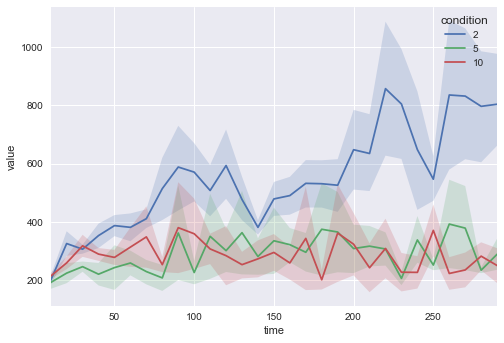

In [20]:
whyseabornwhy = dict(zip(cols, names))
ax = sns.tsplot(hopper_evalrew_df, **whyseabornwhy)
plt.show()

In [21]:
import pandas as pd
from scipy.interpolate import spline

AVG_LEN = 20
SPLINE_POINTS = 50

dataframe_data = []
for k, by_seed in hopper_data.items():
    for s, data in by_seed.items():
        ev_x, ev_y = data['ev_x_by_head'][-1], data['ev_after_y_by_head']
        ev_x = [0] + ev_x + [299]
        ev_y = [0] + ev_y + [ev_y[-1]]
        ev_y = np.clip(ev_y, -1.0, 1.0)
        
        interp_x = np.array(range(300))
        interp_ev_y = np.interp(interp_x, ev_x, ev_y)
        interp_ev_y = np.clip(interp_ev_y, -1.0, 1.0)
        
        avg_ev_y = np.empty(len(interp_ev_y) - AVG_LEN)
        for i, t in enumerate(range(AVG_LEN, len(interp_ev_y))):
            avg_ev_y[i] = np.mean(interp_ev_y[t-AVG_LEN:t])
        avg_x = interp_x[AVG_LEN:]
        
        spline_x = np.linspace(min(avg_x), max(avg_x), SPLINE_POINTS)
        spline_ev_y = spline(avg_x, avg_ev_y, spline_x)
        
        for x, y in zip(spline_x, spline_ev_y):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
names = cols
hopper_ev_df = pd.DataFrame(dataframe_data, 
                            columns=cols)

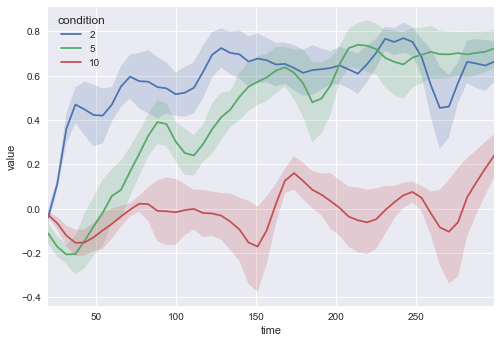

In [22]:
whyseabornwhy = dict(zip(cols, names))
ax = sns.tsplot(hopper_ev_df, **whyseabornwhy)
plt.show()